# Data Science: Coursework 2

### Shri Lekkala
### CID: 01499487

### Table of Contents

* [Task 1](#t1) 
    * [Question 1.1](#q1_1)
        * [Part 1.1.1](#1_1_1)
        * [Part 1.1.2](#1_1_2)
        * [Part 1.1.3](#1_1_3)
    * [Question 1.2](#q1_2)
        * [Part 1.2.1](#1_2_1)
        * [Part 1.2.2](#1_2_2)
        * [Part 1.2.3](#1_2_3)
        * [Part 1.2.4](#1_2_4)
* [Task 2](#t2)
    * [Question 2.1](#q2_1)
        * [Part 2.1.1](#2_1_1)
        * [Part 2.1.2](#2_1_2)
        * [Part 2.1.3](#2_1_3)
    * [Question 2.2](#q2_2)
        * [Part 2.2.1](#2_2_1)
        * [Part 2.2.2](#2_2_2)
    * [Question 2.3](#q2_3)
        * [Part 2.3.1](#2_3_1)
        * [Part 2.3.2](#2_3_2)
        * [Part 2.3.3](#2_3_3)

In [1]:
# Import modules used throughout the coursework
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import time

# Set a random seed to fix the results
np.random.seed(1024)

## Task 1: Neural Networks <a class="anchor" id="t1"></a>
***

### 1.1 Multi-Layer Perceptron <a class="anchor" id="q1_1"></a>
***

#### Question 1.1.1 <a class="anchor" id="1_1_1"></a>
***

First we load the dataset:

In [2]:
def load_data ():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    return ((x_train, y_train), (x_val, y_val))

(x_train, y_train), (x_val, y_val) = load_data()

We can check the shapes of each of the relevant datasets:

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


An example image from the training dataset is plotted below:

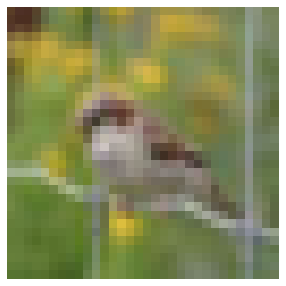

In [4]:
image = x_train[1024]
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

We process the data into numpy arrays for use in this section:

In [5]:
# Convert the data into 2D numpy arrays
X_train_np = np.reshape(np.array(x_train), (50000, 3072), order='C').T
X_test_np = np.reshape(np.array(x_val), (10000, 3072), order='C').T
y_train_np = np.array(y_train).T
y_test_np = np.array(y_val).T

# Convert the vector of labels of 0s and 1s into an integer between 0 and 9
y_train_np_labels = np.argmax(y_train_np, axis = 0)
y_test_np_labels = np.argmax(y_test_np, axis = 0)

Once again we can check their shapes:

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


First we create a function to randomly split the training dataset into batches of 128.

50,000 datapoints means that there will be 391 batches in total.\
Note here we make the final batch also size 128 by including some datapoints from the first batch.

In [7]:
def databatch(batch_size, x_data, y_data):
    n = x_data.shape[0]
    indices = np.arange(n)
    
    # shuffle before each epoch
    np.random.shuffle(indices)
    x_data = x_data[indices]
    y_data = y_data[indices]
    
    batches = [(x_data[k:k+batch_size], y_data[k:k+batch_size]) for k in range(0, n, batch_size)]
    
    # make the last batch the same size as the others by including elements from the start
    k = range(0, 50000, 128)[-1]
    last_batch_x = np.array([x_data[i%n] for i in range(k, k+batch_size)])
    last_batch_y = np.array([y_data[i%n] for i in range(k, k+batch_size)])
    
    batches[-1] = (last_batch_x, last_batch_y)
    
    return batches 

Next we create activation functions for the forward pass in the MLP, and also the derivative of the tanh activation dunction for use in backward pass:

In [8]:
def Tanh(h):
    return np.tanh(h)

def SoftMax(X):
    prob = np.exp(X) /np.sum(np.exp(X), axis=0)
    return prob

def dTanh(a1):
    # Note the derivative of tanh(x) is 1 - tanh^2(x)
    return 1 - np.square(np.tanh(a1))

We also have a function to compute the Cross Entropy Loss, using the formula 

$$ CE = - \sum t_i \log(f(s)_i) $$ where $\mathbf{t}$ is the one-hot truth vector, and $\mathbf{f(s)}$ is the output from the SoftMax activation layer.

In [9]:
def CrossEntropyLoss(y_truth, y_hat_softmax):
    ce_loss = - np.sum(y_truth * np.log(y_hat_softmax)) / y_truth.shape[1]
    return ce_loss

We also create a function for the dense layers to obtain the pre-activation values, and also a function to compute the output_error for use in back propagation:

In [10]:
def dense(h, W, b):
    return b + W @ h

def output_error(y_batch, a6):
    return a6 - y_batch

Throughout this section, I will be using the same notation as defined in the lectures:

Pre-activations: $\mathbf{a}^{(k)} + \mathbf{W}^{(k-1)} \mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} $ \
Post-activations: $\mathbf{h}^{(k)} = \sigma(\mathbf{a}^{(k)}) $

In the code, I store all the relevant parameters in python dictionaries for easy access.\
In particular the pre and post activations of each layer are stored in the dictionary 'activations'\
The weights and biases of the layers are stored in the dictionary 'parameters'\
The relevant gradients for each layer are stored in the dictionary 'gradient'

First we create the function to compute the forward pass, and keep a record of all the pre and post activations in the dictionary:

In [11]:
def forward_pass(X, parameters):
    # create a dictionary to store the pre and post activations
    activations = {}
    
    # Five Hidden Layers
    activations['a1'] = dense(X, parameters['W0'], parameters['b0'])
    activations['h1'] = Tanh(activations['a1'])
    
    activations['a2'] = dense(activations['h1'], parameters['W1'], parameters['b1'])
    activations['h2'] = Tanh(activations['a2'])
    
    activations['a3'] = dense(activations['h2'], parameters['W2'], parameters['b2'])
    activations['h3'] = Tanh(activations['a3'])
    
    activations['a4'] = dense(activations['h3'], parameters['W3'], parameters['b3'])
    activations['h4'] = Tanh(activations['a4'])
    
    activations['a5'] = dense(activations['h4'], parameters['W4'], parameters['b4'])
    activations['h5'] = Tanh(activations['a5'])
    
    # Output Layer
    activations['a6'] = dense(activations['h5'], parameters['W5'], parameters['b5'])
    activations['h6'] = SoftMax(activations['a6'])
    
    return activations

Next, we have a function to compute all the required gradients by back propagation using the pre and post activations obtained from the function above.

We use the rules derived from the lectures:

$\Large{\boldsymbol{\delta_p}^{(k)} := \frac{\partial\mathcal{L}_i}{\partial \boldsymbol{a_p}^{(k)}}}$

$\Large{\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W_{pq}}^{(k)}} = \frac{\partial\mathcal{L}_i}{\partial \boldsymbol{a_p}^{(k+1)}} \cdot h_q^{k}}$

$\Large{\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b_p}^{(k)}} = \frac{\partial\mathcal{L}_i}{\partial \boldsymbol{a_p}^{(k+1)}}}$


Note that we also sum the vector of gradients and divide by the number of datapoints in the batch to get an average value over the batch size.

In [12]:
def back_propagate(X, y, activations, parameters):
    D = X.shape[1]
    
    # create a dictionary to store the gradients
    gradient = {}
    
    gradient['delta6'] = output_error(y, activations['h6'])
    gradient['d_W5'] = gradient['delta6'] @ activations['h5'].T / D
    gradient['d_b5'] = np.sum(gradient['delta6'], axis=1, keepdims=True) / D
    gradient['d_h5'] = parameters['W5'].T @ gradient['delta6']
    
    gradient['delta5'] = gradient['d_h5'] * dTanh(activations['a5'])
    gradient['d_W4'] = gradient['delta5'] @ activations['h4'].T / D
    gradient['d_b4'] = np.sum(gradient['delta5'], axis=1, keepdims=True) / D
    gradient['d_h4'] = parameters['W4'].T @ gradient['delta5']
    
    gradient['delta4'] = gradient['d_h4'] * dTanh(activations['a4'])
    gradient['d_W3'] = gradient['delta4'] @ activations['h3'].T / D
    gradient['d_b3'] = np.sum(gradient['delta4'], axis=1, keepdims=True) / D
    gradient['d_h3'] = parameters['W3'].T @ gradient['delta4']
    
    gradient['delta3'] = gradient['d_h3'] * dTanh(activations['a3'])
    gradient['d_W2'] = gradient['delta3'] @ activations['h2'].T / D
    gradient['d_b2'] = np.sum(gradient['delta3'], axis=1, keepdims=True) / D
    gradient['d_h2'] = parameters['W2'].T @ gradient['delta3']
    
    gradient['delta2'] = gradient['d_h2'] * dTanh(activations['a2'])
    gradient['d_W1'] = gradient['delta2'] @ activations['h1'].T / D
    gradient['d_b1'] = np.sum(gradient['delta2'], axis=1, keepdims=True) / D
    gradient['d_h1'] = parameters['W1'].T @ gradient['delta2']
    
    gradient['delta1'] = gradient['d_h1'] * dTanh(activations['a1'])
    gradient['d_W0'] = gradient['delta1'] @ X.T / D
    gradient['d_b0'] = np.sum(gradient['delta1']) / D

    return gradient

Once we have the all the gradient terms, we can then use stochastic gradient descent to update our parameter values of weights and biases in the direction of the negative gradient with a specified learning rate.

For a general parameter $\theta$, learning rate $\eta$, loss function $L$, mini-batch $\mathcal{D}_m$ and iteration $t$ the update rule is: $\theta_{t+1} = \theta_t - \eta \Delta_{\theta} L (\theta_t; \mathcal{D}_m)$

This function computes these new parameter values and updates the values in the dictionary:

In [13]:
def SGD_optimize(parameters, gradient, learning_rate):
    parameters['W5'] -= learning_rate * gradient['d_W5']
    parameters['b5'] -= learning_rate * gradient['d_b5']
    
    parameters['W4'] -= learning_rate * gradient['d_W4']
    parameters['b4'] -= learning_rate * gradient['d_b4']

    parameters['W3'] -= learning_rate * gradient['d_W3']
    parameters['b3'] -= learning_rate * gradient['d_b3']
    
    parameters['W2'] -= learning_rate * gradient['d_W2']
    parameters['b2'] -= learning_rate * gradient['d_b2']
    
    parameters['W1'] -= learning_rate * gradient['d_W1']
    parameters['b1'] -= learning_rate * gradient['d_b1']
    
    parameters['W0'] -= learning_rate * gradient['d_W0']
    parameters['b0'] -= learning_rate * gradient['d_b0']
    
    return parameters

Finally we have a function that classifies a set of data points $X$ given $X$ and the parameters (weights and biases) of the MLP model by passing through all the dense and activation layers.

The output from the SoftMax layer, h6, is converted into a vector of labels by using argmax. \
However we return both the predictions and h6 in order to compute accuracies and losses respectively.

In [14]:
def get_preds(X, parameters):
    a1 = dense(X, parameters['W0'], parameters['b0'])
    h1 = Tanh(a1)
    
    a2 = dense(h1, parameters['W1'], parameters['b1'])
    h2 = Tanh(a2)
    
    a3 = dense(h2, parameters['W2'], parameters['b2'])
    h3 = Tanh(a3)
    
    a4 = dense(h3, parameters['W3'], parameters['b3'])
    h4 = Tanh(a4)
    
    a5 = dense(h4, parameters['W4'], parameters['b4'])
    h5 = Tanh(a5)
    
    a6 = dense(h5, parameters['W5'], parameters['b5'])
    h6 = SoftMax(a6)
    
    preds = np.argmax(h6, axis=0)
    return h6, preds

Next we have a function to randomly intialise a set of weights to be used at the beginning of model training. The biases are intialised as zero vectors.

The dimensions of the arrays for each parameter depends on the number of neurons in the previous layer and the number of neurons in the next layer.

In [15]:
def initial_parameters(num_h, D):
    # num_h: Number of Neurons in hidden layer
    # D: Number of neurons in layer 0 (Number of inputs)
    # The number of neurons in the last layer (output layer) is fixed at 10
    parameters = {'W0': np.random.randn(num_h, D) * 0.05,
                  'b0': np.zeros((num_h, 1)),
                  
                  'W1': np.random.randn(num_h, num_h) * 0.05,
                  'b1': np.zeros((num_h, 1)),
                    
                  'W2': np.random.randn(num_h, num_h) * 0.05,
                  'b2': np.zeros((num_h, 1)),
                     
                  'W3': np.random.randn(num_h, num_h) * 0.05,
                  'b3': np.zeros((num_h, 1)),
                     
                  'W4': np.random.randn(num_h, num_h) * 0.05,
                  'b4': np.zeros((num_h, 1)),
                     
                  'W5': np.random.randn(10, num_h) * 0.05,
                  'b5': np.zeros((10, 1))}
    
    return parameters

Finally we can create an overall function to train the MLP as required by using all the functions above.

The inputs are the hyperparameters: number of epochs and learning rate.\
The outputs are dictionaries containing the metrics for this model: training & validation losses, training & validation accuracies, total training time.

In [16]:
def MLP(num_epochs, l_rate):
    start = time.time()
    
    # Create lists to store accuracies and losses over the epochs
    Accuracies = []
    Losses = []

    # Set the number of neurons per hidden layer
    num_h = 400
    
    # Get the initialised set of parameters
    Params = initial_parameters(num_h, X_train_np.shape[0])
    
    ## Loop over the epochs
    for i in range(num_epochs):
        
        # Obtain new randomly sampled batches for each epoch
        # (This will return 391 batches of 128 to cover all the 50,000 data points)
        batches = databatch(128, X_train_np.T, y_train_np.T)
        
        # Loop over each batch
        for x_batch, y_batch in batches:
            X = x_batch.T
            y = y_batch.T
        
            # Compute all the pre and post activations in the Forward Pass
            forwardPass = forward_pass(X, Params)
            
            # Back Propagate to find the gradients
            gradient = back_propagate(X, y, forwardPass, Params)
        
            # Update the parameters according to Stochastic Gradient Descent
            Params = SGD_optimize(Params, gradient, l_rate)
        
        # Obtain the predictions and softmax outputs using the model for the training and validation sets
        y_train_softmax, y_train_hat = get_preds(X_train_np, Params)
        y_val_softmax, y_val_hat = get_preds(X_test_np, Params)
        
        # Compute the percentage accuracies
        train_acc = np.sum(y_train_hat == y_train_np_labels) / len(y_train_np_labels)
        val_acc = np.sum(y_val_hat == y_test_np_labels) / len(y_test_np_labels)
        
        # Compute the losses
        train_loss = CrossEntropyLoss(y_train_np, y_train_softmax)
        val_loss = CrossEntropyLoss(y_test_np, y_val_softmax)
        
        # Store the the metrics in the lists
        Losses.append((train_loss, val_loss))
        Accuracies.append(((train_acc, val_acc)))
        
        # Print the progress
        if i%5 == 4:
            print("Epoch " + str(i+1) + "/ 40")
    
    # Calculate the time taken
    time_diff = time.time() - start
    train_time = time.strftime("%H:%M:%S", time.gmtime(time_diff))
    
    # Return the metrics
    return Losses, Accuracies, train_time

As required we train this MLP on batches of 128 datapoints with a learning rate of 0.01 for 40 epochs.\
The metrics obtained are stored in a dictionary.

In [ ]:
MLP_Metrics = {}
MLP_Metrics["40, 0.01"] = MLP(40, 0.01)

Epoch 5/ 40


In [ ]:
print("Final Validation Loss           :", MLP_Metrics["40, 0.01"][0][-1][1])
print('Final Validation Accuracy       :', MLP_Metrics["40, 0.01"][1][-1][1])
print('Total Training Time  : ', MLP_Metrics["40, 0.01"][2])

We then create a function to create plots from the metrics we obtained:

In [ ]:
def MLP_plots(key, lrate):
    # Obtain the metrics
    train_loss = np.array(MLP_Metrics[key][0])[:, 0]
    val_loss = np.array(MLP_Metrics[key][0])[:, 1]
    train_acc = np.array(MLP_Metrics[key][1])[:, 0]
    val_acc = np.array(MLP_Metrics[key][1])[:, 1]
    
    # Plot the metrics
    x_axis = np.arange(40) + 1
    plt.title("Plot of Cross-Entropy losses over Number of Epochs, [Learning Rate = " + lrate + "]")
    plt.plot(x_axis, train_loss, label = "Training Set")
    plt.plot(x_axis, val_loss, label = "Validation Set")
    plt.legend()
    plt.grid()
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss")
    plt.show()
    
    plt.title("Plot of Accuracies over Number of Epochs [Learning Rate = " + lrate + "]")
    plt.plot(x_axis, train_acc, label = "Training Set")
    plt.plot(x_axis, val_acc, label = "Validation Set")
    plt.legend()
    plt.grid()
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy")
    plt.show()
    
    return

In [ ]:
MLP_plots("40, 0.01", "0.01")

#### Question 1.1.2 <a class="anchor" id="1_1_2"></a>
***

We use the same functions above to train the MLP with different learning rates:

In [ ]:
MLP_Metrics["40, 0.0001"] = MLP(40, 0.0001)
print('Total Training Time  : ', MLP_Metrics["40, 0.0001"][2])

MLP_Metrics["40, 0.1"] = MLP(40, 0.1)
print('Total Training Time  : ', MLP_Metrics["40, 0.1"][2])

In [ ]:
The plots obtained are:

In [ ]:
MLP_plots("40, 0.0001", "0.0001")
MLP_plots("40, 0.1", "0.1")

#### Question 1.1.3 <a class="anchor" id="1_1_3"></a>
***

Finally we train the MLP over 80 epochs with the learning rate 0.01 and again plot the metrics:

In [ ]:
MLP_Metrics["80, 0.01"] = MLP(80, 0.01)
print('Total Training Time  : ', MLP_Metrics["80, 0.01"][2])

MLP_plots("80, 0.01", "0.01")

### 1.2 Convolutional Neural Network (CNN) <a class="anchor" id="q1_2"></a>
***

#### Question 1.2.1 <a class="anchor" id="1_2_1"></a>
***

#### Question 1.2.2 <a class="anchor" id="1_2_2"></a>
***

#### Question 1.2.3 <a class="anchor" id="1_2_3"></a>
***

#### Question 1.2.4 <a class="anchor" id="1_2_4"></a>
***

## Task 2: Unsupervised Learning <a class="anchor" id="t2"></a>
***

### 2.1 Clustering of the Feature Matrix <a class="anchor" id="q2_1"></a>
***

#### Question 2.1.1 <a class="anchor" id="2_1_1"></a>
***

#### Question 2.1.2 <a class="anchor" id="2_1_2"></a>
***

#### Question 2.1.3 <a class="anchor" id="2_1_3"></a>
***

### 2.2 Dimensionality Reduction of the Feature Matrix <a class="anchor" id="q2_2"></a>
***

#### Question 2.2.1 <a class="anchor" id="2_2_1"></a>
***

#### Question 2.2.2 <a class="anchor" id="2_2_2"></a>
***

### 2.3 Graph-Based Analysis <a class="anchor" id="q2_3"></a>
***

#### Question 2.3.1 <a class="anchor" id="2_3_1"></a>
***

#### Question 2.3.2 <a class="anchor" id="2_3_2"></a>
***

#### Question 2.3.3 <a class="anchor" id="2_3_3"></a>
***

## End of Coursework